# Summary:
This notebook will cover building an LSTM model and training on the abstracts labeled with cancer type information. The aim is to predict cancer type for the abstracts with no cancer type information.

# Table of contents
* [1. Text preprocessing](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Remove stopwords and custom words](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Vectorize corpus of text](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 Build embedding matrix](#Part1.3_link)
* [2. Training/Validation/Testing datasets preparation](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Split labeled abstracts to training/validation/testing datasets](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Padding sequence](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;[2.3 Generate TensorDataset and DataLoader](#Part2.3_link)
* [3. Build LSTM model](#Part3_link)
* [4. Train LSTM model](#Part4_link)
* [5. Model evaluation](#Part5_link)
<br >&nbsp;&nbsp;&nbsp;[5.1 Visualize training performance](#Part5.1_link)
<br >&nbsp;&nbsp;&nbsp;[5.2 Evaluate model on testing dataset](#Part5.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1 Confusion matrix](#Part5.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2 Prediction accuracy](#Part5.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2.3 ROC curve](#Part5.2.3_link)
* [6. Make prediction](#Part6_link)
<br >&nbsp;&nbsp;&nbsp;[6.1 Predict cancer type for the unlabeled abstracts](#Part6.1_link)
<br >&nbsp;&nbsp;&nbsp;[6.2 Compare LSTM prediction results to hand labeling](#Part6.2_link)
* [7. Evaluate the prediction results across different cancer types](#Part7_link)
* [8. Merge prediction files](#Part8_link)
<br >&nbsp;&nbsp;&nbsp;[8.1 Generate abstract files with new prediction results](#Part8.1_link)
<br >&nbsp;&nbsp;&nbsp;[8.2 Compare cancer type information in labeled and unlabeled corpus](#Part8.2_link)

In [80]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from collections import defaultdict
import itertools

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from keras.preprocessing import text
from keras.preprocessing import sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
abstract_df=pd.read_csv(os.path.join(base_dir, 'data/abstract_citation_df_50930.csv'),index_col='pmid')
cancertype_flattened_df=pd.read_csv(os.path.join(base_dir, "data/cancertype_df2.csv"))

In [4]:
print('Number of abstracts have cancer type information: {}'.format(cancertype_flattened_df.pmid.nunique()))
print("Number of abstracts don't have cancer type information: {}".format(abstract_df.shape[0]-cancertype_flattened_df.pmid.nunique()))

Number of abstracts have cancer type information: 42455
Number of abstracts don't have cancer type information: 8475


In [5]:
abstract_train_df=abstract_df.loc[cancertype_flattened_df.pmid.unique(),:]
abstract_test_df=abstract_df.loc[np.setdiff1d(abstract_df.index, cancertype_flattened_df.pmid.unique()),:]
print('abstract_train_df.shape: {}'.format(abstract_train_df.shape))
print('abstract_test_df.shape: {}'.format(abstract_test_df.shape))

abstract_train_df.shape: (42455, 8)
abstract_test_df.shape: (8475, 8)


**Note**: Here **abstract_test_df** means unlabeled abstracts with no clear cancer type information.

<a id='Part1_link'></a>
# 1. Text preprocessing

<a id='Part1.1_link'></a>
## 1.1 Remove stopwords and custom words

For text preprocessing, in addition to removing common stopwords and punctuation, cancer-related words used to annotate cancer types in Part II also need to be avoided.

In [6]:
#stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
#stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
cancertype_words = ['adrenocortical', 'anal', 'appendix', 'bladder', 'bone', 'breast', 'cervical', 'gallbladder', 'ovarian', 'penile', 'prostate', 'rectal', 'skin', 'thyroid', 'vaginal', 'vulvar', 'urethral', 'parathyroid',
                    'carcinoid', 'pituitary', 'wilms', 'rhabdoid', 'melanoma', 'mesothelioma', 'neuroblastoma', 'osteosarcoma', 'pheochromocytoma', 'retinoblastoma', 'rhabdomyosarcoma', 'sarcoma',
                    'bile', 'colorectal', 'colon', 'cardiac', 'heart', 'endometrial', 'uterine', 'endometrium', 'uterus', 'esophageal', 'esophagus', 'ewing', 'sarcoma', 'fallopian', 'gastric', 'stomach', 'gastrointestinal',
                    'esthesioneuroblastoma', 'hypopharyngeal', 'laryngeal', 'nasopharyngeal', 'pharyngeal', 'salivary', 'oropharyngeal', 'neck', 'kidney', 'renal', 'leukemia', 'liver', 'hepatocellular', 'hepatocyte', 'hepatoblastoma',
                    'lung', 'bronchial', 'pleuropulmonar', 'tracheobronchial', 'non-small', 'lymphoma', 'non-hodgkin', 'hodgkin', 'burkitt', 'myeloma', 'myeloproliferative', 'myelodysplastic', 'pancreatic', 'pancreas', 'testicular', 'testicle', 'testicles', 'testis',
                    'Lung', 'Breast', 'Colon', 'Kidney', 'Leukemia', 'Lymphoma', 'brain', 'Brain']
#stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words+cancertype_words)   ## 572
stop_words = set(list(punct)+cancertype_words)   ## 143

In [7]:
print(len(stop_words))

145


In [14]:
def preprocess(text):
    result=[]
    for sent in sent_tokenize(text):
        for token in word_tokenize(sent):
            if token.lower() not in stop_words:
                result.append(token)
    return " ".join(result)

In [16]:
abstract_train_df['abstract_clean'] = abstract_train_df.abstract.apply(lambda x:preprocess(x))
abstract_test_df['abstract_clean'] = abstract_test_df.abstract.apply(lambda x:preprocess(x))

In [17]:
cancer_types= np.array(cancertype_flattened_df.cancer_type.value_counts().index)
print('Number of cancer types: {}'.format(len(cancer_types)))

Number of cancer types: 55


In [18]:
abstract_train_df['pmid']=abstract_train_df.index
for i in cancer_types:
    cancer_pmid=cancertype_flattened_df[cancertype_flattened_df.cancer_type==i].pmid.unique()
    print('{} articles for {}'.format(len(cancer_pmid), i))
    abstract_train_df[i]=abstract_train_df.pmid.apply(lambda x: 1 if x in cancer_pmid else 0)

7757 articles for Breast Cancer
5201 articles for Lung Cancer
4755 articles for Leukemia
3878 articles for Prostate Cancer
3412 articles for Colorectal Cancer
2939 articles for Lymphoma
2788 articles for Bone Cancer
2459 articles for Melanoma
2422 articles for Liver Cancer
2262 articles for Kidney Cancer
2216 articles for Ovarian Cancer
1992 articles for Pancreatic Cancer
1956 articles for Brain Tumor
1914 articles for Head and Neck Cancer
1488 articles for Acute Myeloid Leukemia (AML)
1413 articles for Multiple Myeloma
1407 articles for Sarcoma
1013 articles for Bladder Cancer
1008 articles for Skin Cancer
996 articles for Gastric Cancer
989 articles for Gastrointestinal Tumor
962 articles for Endometrial Cancer
903 articles for Acute Lymphoblastic Leukemia (ALL)
803 articles for Chronic Lymphocytic Leukemia (CLL)
797 articles for Cardiac Tumors
788 articles for Cervical Cancer
745 articles for Esophageal Cancer
687 articles for Thyroid Cancer
655 articles for Rectal Cancer
573 articl

In [19]:
abstract_train_df['Breast Cancer'].value_counts()

0    34698
1     7757
Name: Breast Cancer, dtype: int64

<a id='Part1.2_link'></a>
## 1.2 Vectorize corpus of text

In [22]:
## generate vocabulary based on a list of texts.
tokenizer=text.Tokenizer()
tokenizer.fit_on_texts(list(abstract_train_df.abstract_clean)+list(abstract_test_df.abstract_clean))

In [25]:
print('Total number of documents: {}'.format(tokenizer.document_count))
print('Size of the vocabulary: {}'.format(len(tokenizer.word_index.keys())))
print('-'*80)
print("Here are examples of 'tokenizer.word_index':")
print(list(tokenizer.word_index.keys())[:10])
print(list(tokenizer.word_index.values())[:10])

Total number of documents: 50930
Size of the vocabulary: 80064
--------------------------------------------------------------------------------
Here are examples of 'tokenizer.word_index':
['of', 'and', 'the', 'in', 'with', 'to', 'patients', 'a', 'for', 'was']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [26]:
## Transforms each text in texts to a sequence of integers.
abstract_train_df['text_clean_seq']=tokenizer.texts_to_sequences(abstract_train_df.abstract_clean)
abstract_test_df['text_clean_seq']=tokenizer.texts_to_sequences(abstract_test_df.abstract_clean)

<a id='Part1.3_link'></a>
## 1.3 Build embedding matrix

In [27]:
CRAWL_EMBEDDING_PATH = '/Volumes/Yuchen_Drive/Toxic_Comment/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '/Volumes/Yuchen_Drive/Toxic_Comment/glove.840B.300d.txt'

In [28]:
def get_coefs(word, *arr):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    with open(path) as f:
        return dict([get_coefs(*line.strip().split(' ')) for line in tqdm(f)])

In [29]:
def build_matrix(word_index, path):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index)+1, 300))
    unknown_words = []
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [32]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print("Number of total features: {}".format(len(tokenizer.word_index)))
print('Number of unknown words (crawl): {}'.format(len(unknown_words_crawl)))
print('Number of unknown words (glove): {}'.format(len(unknown_words_glove)))


Number of total features: 80064
Number of unknown words (crawl): 34158
Number of unknown words (glove): 35005


In [33]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis = 1)
print("crawl_matrix: {}".format(crawl_matrix.shape))
print("glove_matrix: {}".format(glove_matrix.shape))
print("embedding_matrix: {}".format(embedding_matrix.shape))

crawl_matrix: (80065, 300)
glove_matrix: (80065, 300)
embedding_matrix: (80065, 600)


In [34]:
del crawl_matrix
del glove_matrix

<a id='Part2_link'></a>
# 2. Training/Validation/Testing datasets preparation

An LSTM will be trained for each cancer type separately and therefore it is a binary classification problem for each cancer type. For each cancer type, the abstract discussing the specific cancer type is classified in 'Class1' otherwise 'Class0'. The dataset is very imbalanced for some rare cancer types. Thus, only the top29 cancer types will be trained to annotate the unlabeled abstracts.

In [35]:
cancer_prefix_dict={'Breast Cancer':'Doctor_recommendation_RNN4_breast_epoch100_lr5_gpu',
                   'Lung Cancer':'Doctor_recommendation_RNN4_lung_epoch100_lr5_gpu',
                   'Leukemia':'Doctor_recommendation_RNN4_leukemia_epoch100_lr5_gpu',
                   'Prostate Cancer':'Doctor_recommendation_RNN4_prostate_epoch100_lr5_gpu',
                   'Colorectal Cancer':'Doctor_recommendation_RNN4_colorectal_epoch100_lr5_gpu',
                   'Lymphoma':'Doctor_recommendation_RNN4_lymphoma_epoch100_lr5_gpu',
                   'Bone Cancer':'Doctor_recommendation_RNN4_bone_epoch100_lr5_gpu',
                   'Melanoma':'Doctor_recommendation_RNN4_melanoma_epoch100_lr5_gpu',
                   'Liver Cancer':'Doctor_recommendation_RNN4_liver_epoch100_lr5_gpu',
                   'Kidney Cancer':'Doctor_recommendation_RNN4_kidney_epoch100_lr5_gpu',
                   'Ovarian Cancer':'Doctor_recommendation_RNN4_ovarian_epoch100_lr5_gpu',
                   'Pancreatic Cancer':'Doctor_recommendation_RNN4_pancreatic_epoch100_lr5_gpu',
                   'Brain Tumor':'Doctor_recommendation_RNN4_brain_epoch100_lr5_gpu',
                   'Head and Neck Cancer':'Doctor_recommendation_RNN4_head_and_neck_epoch100_lr5_gpu',
                   'Acute Myeloid Leukemia (AML)':'Doctor_recommendation_RNN4_aml_epoch100_lr5_gpu',
                   'Multiple Myeloma':'Doctor_recommendation_RNN4_multiple_myeloma_epoch100_lr5_gpu',
                   'Sarcoma':'Doctor_recommendation_RNN4_sarcoma_epoch100_lr5_gpu',
                   'Bladder Cancer':'Doctor_recommendation_RNN4_bladder_epoch100_lr5_gpu',
                   'Skin Cancer':'Doctor_recommendation_RNN4_skin_epoch100_lr5_gpu',
                   'Gastric Cancer':'Doctor_recommendation_RNN4_gastric_epoch100_lr5_gpu',
                   'Gastrointestinal Tumor':'Doctor_recommendation_RNN4_gastrointestinal_epoch100_lr5_gpu',
                   'Endometrial Cancer':'Doctor_recommendation_RNN4_endometrial_epoch100_lr5_gpu',
                   'Acute Lymphoblastic Leukemia (ALL)':'Doctor_recommendation_RNN4_all_epoch100_lr5_gpu',
                   'Chronic Lymphocytic Leukemia (CLL)':'Doctor_recommendation_RNN4_cll_epoch100_lr5_gpu',
                   'Cardiac Tumors':'Doctor_recommendation_RNN4_cardiac_epoch100_lr5_gpu',
                   'Cervical Cancer':'Doctor_recommendation_RNN4_cervical_epoch100_lr5_gpu',
                   'Esophageal Cancer':'Doctor_recommendation_RNN4_esophageal_epoch100_lr5_gpu',
                   'Thyroid Cancer':'Doctor_recommendation_RNN4_thyroid_epoch100_lr5_gpu',
                   'Rectal Cancer':'Doctor_recommendation_RNN4_rectal_epoch100_lr5_gpu'
                   }

Since the training process is redundant for different cancer types, here I will only show Breast Cancer as an example of how to train an LSTM to predict whether an article is discussing Breast Cancer in the unlabeled abstracts.

In [36]:
## cancer_type can be replaced by other cancer types
cancer_type='Breast Cancer'
prefix=cancer_prefix_dict[cancer_type]

Check the distribution of text length for abstracts in 'Class0' and 'Class1' for 'Breast Cancer'.

In [40]:
abstract_train_df['text_length']=abstract_train_df['abstract_clean'].apply(lambda x:len(x))

Text(0, 0.5, 'Density')

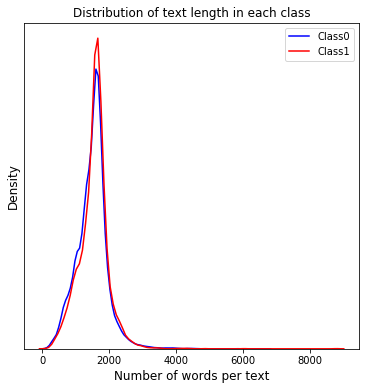

In [41]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','red']
for i in range(2):
    sns.distplot(abstract_train_df[abstract_train_df[cancer_type]==i].text_length,color=palette[i],hist=False,ax=ax,label='Class{}'.format(i))
ax.set_title('Distribution of text length in each class',fontsize=12)
ax.set_xlabel('Number of words per text', fontsize=12)
ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

The distribution of text length is comparable between Class0 and Class1. Therefore, we will move foward to spliting the data into training, validation and testing datasets.

<a id='Part2.1_link'></a>
## 2.1 Split labeled abstracts to training/validation/testing datasets

Abstracts in abstract_train_df need to be splitted in training, validation and testing datasets, with the same ratio of positive (eg. Breast Cancer) related articles.

In [39]:
train_set,val_set=train_test_split(abstract_train_df,train_size=0.8,stratify=abstract_train_df[cancer_type],random_state=8)
val_set,test_set=train_test_split(val_set,train_size=0.5,stratify=val_set[cancer_type],random_state=8)
print('Number of samples in training set: {}'.format(train_set.shape[0]))
print('Number of samples in validation set: {}'.format(val_set.shape[0]))
print('Number of samples in testing set: {}'.format(test_set.shape[0]))
print('Number of samples in prediction dataset: {}'.format(abstract_test_df.shape[0]))

Number of samples in training set: 33964
Number of samples in validation set: 4245
Number of samples in testing set: 4246
Number of samples in prediction dataset: 8475


<a id='Part2.2_link'></a>
## 2.2 Padding sequence

The **MAX_LEN** needs to be specified when padding sequence. Based on the distribution of text length above, 2000 is chosen as MAX_LEN.

In [63]:
## Pads sequences to the same length.
MAX_LEN=2000
train_x=sequence.pad_sequences(train_set.text_clean_seq,maxlen=MAX_LEN)
val_x=sequence.pad_sequences(val_set.text_clean_seq,maxlen=MAX_LEN)
test_x=sequence.pad_sequences(test_set.text_clean_seq,maxlen=MAX_LEN)
pred_x=sequence.pad_sequences(abstract_test_df.text_clean_seq,maxlen=MAX_LEN)

In [64]:
print('train_x.shape: {}'.format(train_x.shape))
print('val_x.shape: {}'.format(val_x.shape))
print('test_x.shape: {}'.format(test_x.shape))
print('pred_x.shape: {}'.format(pred_x.shape))

train_x.shape: (33964, 2000)
val_x.shape: (4245, 2000)
test_x.shape: (4246, 2000)
pred_x.shape: (8475, 2000)


<a id='Part2.3_link'></a>
## 2.3 Generate TensorDataset and DataLoader

In [66]:
train_data=TensorDataset(torch.tensor(train_x, dtype=torch.long),torch.tensor((train_set[cancer_type]).to_numpy(), dtype=torch.long))
val_data=TensorDataset(torch.tensor(val_x, dtype=torch.long),torch.tensor((val_set[cancer_type]).to_numpy(), dtype=torch.long))
test_data=TensorDataset(torch.tensor(test_x, dtype=torch.long),torch.tensor((test_set[cancer_type]).to_numpy(), dtype=torch.long))
pred_data=TensorDataset(torch.tensor(pred_x, dtype=torch.long))


In [68]:
# BATCH_SIZE=128
BATCH_SIZE=64
train_loader=DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(val_data,shuffle=True,batch_size=BATCH_SIZE)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE)
pred_loader=DataLoader(pred_data,batch_size=BATCH_SIZE)

In [69]:
inputs,labels=next(iter(train_loader))
print('Input size: {}'.format(inputs.shape))
print('labels size: {}'.format(labels.shape))

Input size: torch.Size([64, 2000])
labels size: torch.Size([64])


<a id='Part3_link'></a>
# 3. Build LSTM model

In [70]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [71]:
class DR_RNN(nn.Module):
    """
    The RNN model that will be used to perform Cancer type classification.
    """

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(DR_RNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.conv1_1 = nn.Conv1d(600,256,3,padding=1)
        self.conv1_2 = nn.Conv1d(256,128,1,padding=0)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(128, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.pool = nn.MaxPool1d(2,2)
        
        self.linear1 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear_out = nn.Linear(hidden_dim * 4, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([64, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        ## Conv1d
        embeds=embeds.permute(0,2,1)   ## embeds_pre_conv: torch.Size([128, 600, 2000])   torch.Size([BATCH_SIZE, embedding_dim, MAX_LEN])
        # print("embeds_pre_conv: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_1(embeds))   ## embeds_conv1_1: torch.Size([128, 256, 2000])
        # print("embeds_conv1_1: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_2(embeds))   ## embeds_conv1_2: torch.Size([128, 128, 2000])
        # print("embeds_conv1_2: {}".format(embeds.shape))
        embeds = self.pool(embeds)   ## embeds_conv1_2_maxpool: torch.Size([128, 128, 1000])
        # print("embeds_conv1_2_maxpool: {}".format(embeds.shape))
        embeds = self.dropout(embeds)
        embeds=embeds.permute(0,2,1)   ## embeds_post_conv: torch.Size([128, 1000, 128])   torch.Size([BATCH_SIZE, MAX_LEN/2, *])
        # print("embeds_post_conv: {}".format(embeds.shape))
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm2: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 256])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 256])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 512])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([128, 512])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc)))   ## h_conc_linear2: torch.Size([128, 512])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 512])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [72]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DR_RNN(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)
print(model)

DR_RNN(
  (embedding): Embedding(80065, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (conv1_1): Conv1d(600, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (lstm1): LSTM(128, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_out): Linear(in_features=512, out_features=9, bias=True)
)


<a id='Part4_link'></a>
# 4. Train LSTM model

The dataset is imbalanced. To make a balance between precision and recall, I choose to use F1 score as the evaluation metric and save the trained LSTM model with the highest F1 score.

In [54]:
def DR_RNN_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''
    Corresponding to DR_RNN, with nn.CrossEntropyLoss() as criterion
    '''
    epoch_dict={}
    valid_loss_min = np.Inf
    valid_f1_max = 0
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        dt = np.dtype(int)
        train_pred_array = np.array([], dtype = dt)
        train_y_array = np.array([], dtype = dt)
        val_pred_array = np.array([], dtype = dt)
        val_y_array = np.array([], dtype = dt)
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            #print('Step1')
            loss = criterion(output, labels)
            #print(loss)
            loss.backward()
            #print('Step2')
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            ## Update loss and acc values for the training process
            # print(loss)
            train_loss += loss.item()*inputs.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            if device.type == 'cpu':
                train_pred_array = np.append(train_pred_array, torch.reshape(top_class, labels.shape).numpy())
                train_y_array = np.append(train_y_array, labels.numpy())
            else:
                train_pred_array = np.append(train_pred_array, torch.reshape(top_class.cpu(), labels.cpu().shape).numpy())
                train_y_array = np.append(train_y_array, labels.cpu().numpy())
        
        else:
            # print("validation starts")
            with torch.no_grad():
                model.eval()
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    output = model(inputs)
                    loss = criterion(output, labels)
                    # print(loss)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*inputs.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
                    if device.type == 'cpu':
                        val_pred_array = np.append(val_pred_array, torch.reshape(top_class, labels.shape).numpy())
                        val_y_array = np.append(val_y_array, labels.numpy())
                    else:
                        val_pred_array = np.append(val_pred_array, torch.reshape(top_class.cpu(), labels.cpu().shape).numpy())
                        val_y_array = np.append(val_y_array, labels.cpu().numpy())
        
                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)
                epoch_dict[epoch]['Train_F1'] = f1_score(train_y_array, train_pred_array)
                epoch_dict[epoch]['Val_F1'] = f1_score(val_y_array, val_pred_array)
                
                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Train F1: {:.3f}..".format(f1_score(train_y_array, train_pred_array)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)),
                      "Validation F1: {:.3f}..".format(f1_score(val_y_array, val_pred_array)))
                
                ## save the model with the highest val_f1 and update valid_loss_min
                #if val_loss <= valid_loss_min:
                val_f1 = f1_score(val_y_array, val_pred_array)
                if val_f1 >= valid_f1_max:
                    #print('Validation loss decreased -- Saving model -- \n')
                    print('Validation F1 increased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_f1_max = val_f1
                
    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [56]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DR_RNN(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 100
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models_2/{}.pth'.format(prefix))
model, epoch_df = DR_RNN_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models_2/{}.csv'.format(prefix)),index=False)

The model is trained on GPU and the results are displayed below.

<a id='Part5_link'></a>
# 5. Model evaluation

Here is a list of functions used in training performance evaluation.

In [57]:
def plot_loss_accuracy_curve(epoch_df,cancer_type):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('{}\nTraining and Validation Loss'.format(cancer_type), fontsize=12)

    plt.subplot(1,3,2)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.title('{}\nTraining and Validation Accuracy'.format(cancer_type), fontsize=12)
    
    plt.subplot(1,3,3)
    plt.plot(epoch_df.Epoch, epoch_df.Train_F1, label = 'Training F1')
    plt.plot(epoch_df.Epoch, epoch_df.Val_F1, label = 'Validation F1')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('F1_score', fontsize=12)
    plt.legend()
    plt.title('{}\nTraining and Validation F1'.format(cancer_type), fontsize=12)
    plt.tight_layout()

In [58]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black",fontsize=16)

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()

In [59]:
def plot_acc_bar(cm,title=''):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.ylim(0,110)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Accuracy%', fontsize=12)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontsize=12)
    plt.title(title)

In [60]:
def plot_ROC_curve(y_true, y_score,title=''):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = 'blue', label='ROC curve (area = {:.2f})'.format(auc_value))
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False positive rate',fontsize=12)
    plt.ylabel('True positive rate',fontsize=12)
    plt.title('ROC curve')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(fontsize=16)
    plt.title(title,fontsize=16)
    plt.show()

In [61]:
def DR_RNN_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,len(classes)+1).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()*inputs.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(2)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return summary_df, pred_df

<a id='Part5.1_link'></a>
## 5.1 Visualize training performance

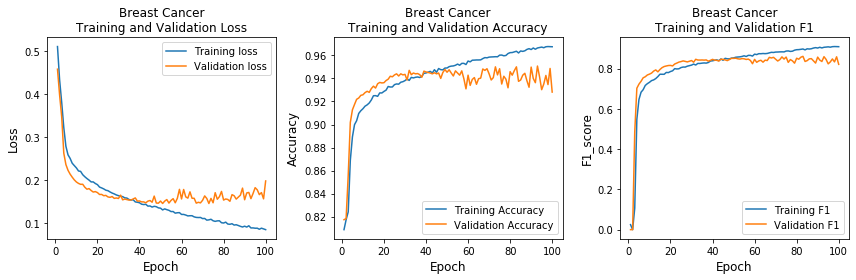

In [62]:
## Models were trained in HPC and output scores are uploaded here.
## Doctor_recommendation_RNN4_all_epoch100_lr5_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models_2/{}.csv'.format(prefix)))
plot_loss_accuracy_curve(epoch_df,cancer_type)

<a id='Part5.2_link'></a>
## 5.2 Evaluate model on testing dataset

In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 2
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DR_RNN(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models_2/{}.pth'.format(prefix)), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models_2/{}.pth'.format(prefix)))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [75]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i) for i in np.arange(2)])
summary_df, pred_df = DR_RNN_eval(test_loader, model, criterion, device, classes)

Test Loss: 0.145830

Test Accuracy (Overall): 94.795%  (4025.0/4246.0)

Test Accuracy of Class_0: 96.830% (3360.0/3470.0)
Test Accuracy of Class_1: 85.696% (665.0/776.0)


In [76]:
summary_df.head()

,category,correct,total
0,Class_0,3360.0,3470.0
1,Class_1,665.0,776.0


In [78]:
pred_df.head()

,true_label,prediction,prob,class_0,class_1
0,1,1,0.999135,0.000865,0.999135
1,0,0,0.999180,0.999180,0.000820
2,0,0,0.998900,0.998900,0.001100
3,0,1,0.721046,0.278954,0.721046
4,0,0,0.970856,0.970856,0.029144


In [ ]:
summary_df.to_csv(os.path.join(base_dir,'models/{}_summary_df.csv'.format(prefix)),index=False)
pred_df.to_csv(os.path.join(base_dir,'models/{}_pred_df.csv'.format(prefix)),index=False)

<a id='Part5.2.1_link'></a>
### 5.2.1 Confusion matrix

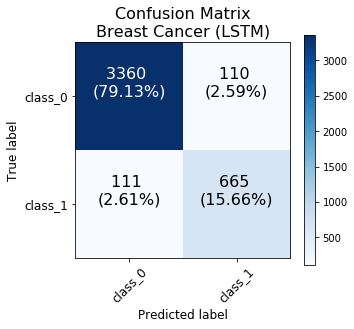

In [81]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(2)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nBreast Cancer (LSTM)', cmap=plt.cm.Blues)

<a id='Part5.2.2_link'></a>
### 5.2.2 Prediction accuracy

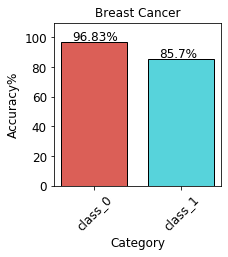

In [82]:
plot_acc_bar(cm,title='Breast Cancer')

<a id='Part5.2.3_link'></a>
### 5.2.3 ROC curve

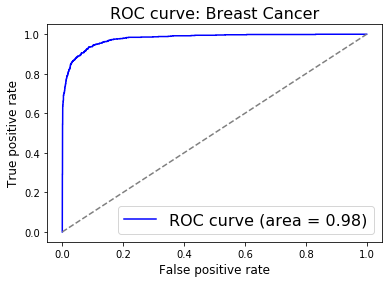

In [83]:
plot_ROC_curve(pred_df.true_label.values, pred_df.class_1.values, title='ROC curve: Breast Cancer')

In [84]:
print('f1 score: {}'.format(f1_score(pred_df.true_label.values, pred_df.prediction)))

f1 score: 0.8575112830431979


<a id='Part6_link'></a>
# 6. Make prediction

The goal of the trained LSTM model is to predict cancer type in the unlabeled abstract corpus.

<a id='Part6.1_link'></a>
## 6.1 Predict cancer type for the unlabeled abstracts

In [85]:
def DR_RNN_pred(test_loader, model, device):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    
    dt = np.dtype(int)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,len(classes)+1).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for inputs in test_loader:
            inputs=inputs[0]
            inputs = inputs.to(device)
            output = model(inputs)
            
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            
            if device.type == 'cpu':
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
    pred_df = pd.DataFrame({'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(2)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return pred_df

In [87]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 2
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = DR_RNN(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models_2/{}.pth'.format(prefix)), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models_2/{}.pth'.format(prefix)))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [89]:
pred_df = DR_RNN_pred(pred_loader, model, device)
pred_df.index=abstract_test_df.index
pred_df.rename(columns={'prediction':cancer_type},inplace=True)
pred_df.head()

,Breast Cancer,prob,class_0,class_1
pmid,,,,
10037348,0,0.983567,0.983567,0.016433
10873802,0,0.967321,0.967321,0.032679
11050493,0,0.992642,0.992642,0.007358
11096383,0,0.987932,0.987932,0.012068
11734111,0,0.646896,0.646896,0.353104


In [ ]:
pred_df.to_csv(os.path.join(base_dir,'models_2/{}_test_df.csv'.format(prefix)),index=True,index_label='pmid')

<a id='Part6.2_link'></a>
## 6.2 Compare LSTM prediction results to hand labeling

To make sure that the trained LSTM model can really predict cancer types in the unlabeled abstract corpus, I also hand-labeled 500 abstracts in the unlabeled group to compare the results to those predicted by LSTM.

In [90]:
pred_df2=pd.read_csv(os.path.join(base_dir, 'models/{}_pred_df_manual.csv'.format(prefix)))

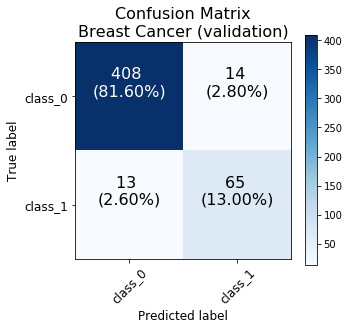

In [91]:
cm = confusion_matrix(pred_df2.true_label, pred_df2.prediction)
classes = ['class_{}'.format(i) for i in range(2)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nBreast Cancer (validation)', cmap=plt.cm.Blues)

As we can see, the prediction performance for the trained LSTM is comparable between labeled and unlabeled abstracts.

<a id='Part7_link'></a>
# 7. Evaluate the prediction results across different cancer types

In [92]:
class0_acc_dict = {}
class1_acc_dict = {}
recall_dict = {}
precision_dict = {}
f1_dict = {}
auc_score_dict = {}

In [93]:
def RNN_val_performance(cancer_type):
    prefix=cancer_prefix_dict[cancer_type]
    summary_df = pd.read_csv(os.path.join(base_dir,'models_2/{}_summary_df.csv'.format(prefix)))
    pred_df = pd.read_csv(os.path.join(base_dir,'models_2/{}_pred_df.csv'.format(prefix)))
    class0_acc_dict[cancer_type] = summary_df.correct[0]/summary_df.total[0]
    class1_acc_dict[cancer_type] = summary_df.correct[1]/summary_df.total[1]
    recall_dict[cancer_type] = recall_score(pred_df.true_label, pred_df.prediction)
    precision_dict[cancer_type] = precision_score(pred_df.true_label, pred_df.prediction)
    f1_dict[cancer_type] = f1_score(pred_df.true_label, pred_df.prediction)
    auc_score_dict[cancer_type] = roc_auc_score(pred_df.true_label, pred_df.class_1)

In [94]:
for cancer_type in np.array(cancertype_flattened_df.cancer_type.value_counts().index)[:29]:
    RNN_val_performance(cancer_type)

In [95]:
df1 = pd.DataFrame.from_dict(class0_acc_dict, orient='index', columns=['class0_acc'])
df2 = pd.DataFrame.from_dict(class1_acc_dict, orient='index', columns=['class1_acc'])
df3 = pd.DataFrame.from_dict(recall_dict, orient='index', columns=['recall_score'])
df4 = pd.DataFrame.from_dict(precision_dict, orient='index', columns=['precision_score'])
df5 = pd.DataFrame.from_dict(f1_dict, orient='index', columns=['f1_score'])
df6 = pd.DataFrame.from_dict(auc_score_dict, orient='index', columns=['auc_score'])

In [96]:
dl_summary_df=pd.concat([df1,df2,df3,df4,df5,df6],axis=1,sort=False)

In [97]:
dl_summary_df.head()

,class0_acc,class1_acc,recall_score,precision_score,f1_score,auc_score
Breast Cancer,0.968300,0.856959,0.856959,0.858065,0.857511,0.978546
Lung Cancer,0.984432,0.744231,0.744231,0.869663,0.802073,0.956631
Leukemia,0.997613,0.937960,0.937960,0.980220,0.958624,0.995662
Prostate Cancer,0.993260,0.793814,0.793814,0.922156,0.853186,0.977347
Colorectal Cancer,0.983993,0.683284,0.683284,0.788494,0.732129,0.960221


In [ ]:
dl_summary_df.to_csv(os.path.join(base_dir, 'models/dl_dummary_df.csv'),index=True,index_label='cancer_type')

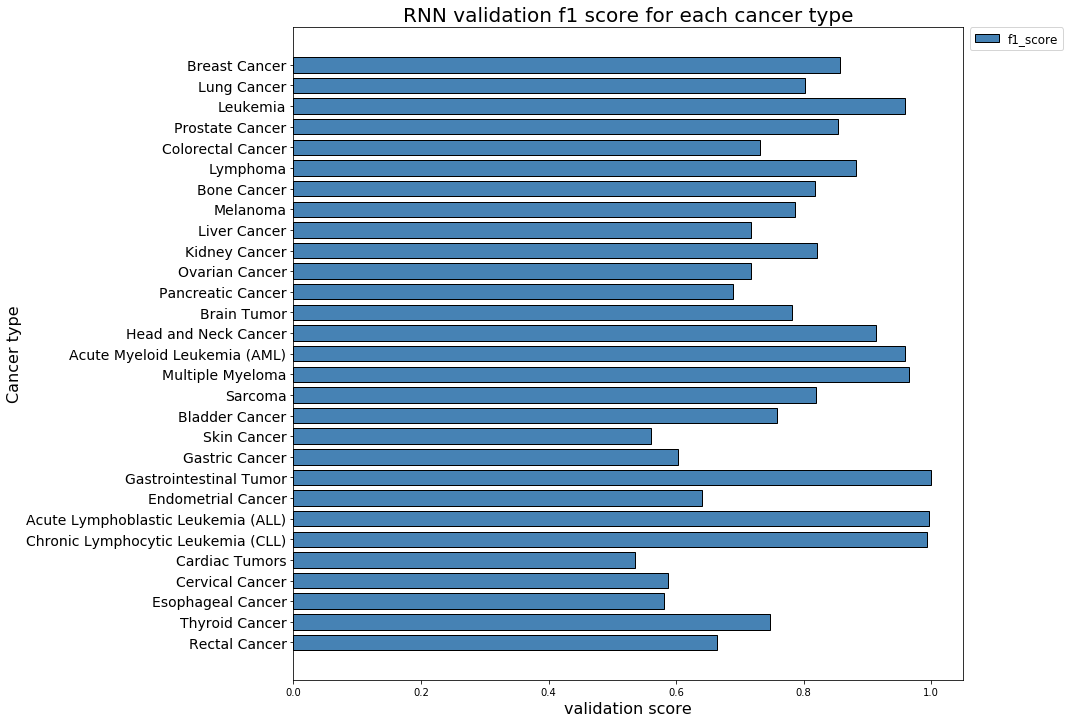

In [98]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(dl_summary_df))  # the x locations for the groups
ax.barh(ind, dl_summary_df.f1_score, width, edgecolor='black',color='steelblue',label='f1_score')
ax.invert_yaxis()
plt.yticks(ind, labels = dl_summary_df.index, fontsize=12)
plt.yticks(fontsize=14)
#plt.ylim(0,110)
plt.ylabel('Cancer type', fontsize=16)
plt.xlabel('validation score', fontsize=16)
plt.title('RNN validation f1 score for each cancer type', fontsize=20)
plt.legend(fontsize=12,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [102]:
dl_summary_df=dl_summary_df.loc[:,['class0_acc', 'class1_acc', 'auc_score', 'recall_score', 'precision_score', 'f1_score']]
dl_mean = dl_summary_df.mean()
dl_std = dl_summary_df.std()

Text(0.5, 1.0, 'Training performance for LSTM across cancer types')

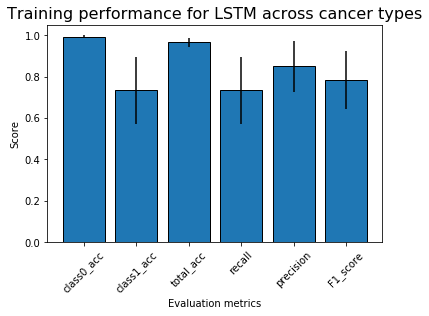

In [115]:
plt.bar(np.arange(6), dl_mean, yerr=dl_std, edgecolor='black')
plt.xticks(np.arange(6), ['class0_acc', 'class1_acc', 'total_acc', 'recall', 'precision', 'F1_score'],rotation=45)
plt.xlabel('Evaluation metrics')
plt.ylabel('Score')
plt.title('Training performance for LSTM across cancer types',fontsize=16)

<a id='Part8_link'></a>
# 8. Merge prediction files

<a id='Part8.1_link'></a>
## 8.1 Generate abstract files with new prediction results

In [116]:
abstract_test_df['pmid']=abstract_test_df.index

In [118]:
test_df_list=[abstract_test_df]
for i in cancer_types[:29]:
    file_name=cancer_prefix_dict[i]+'_test_df.csv'
    file=pd.read_csv(os.path.join(base_dir+'/models_2', file_name),index_col='pmid').drop(['prob','class_0','class_1'],axis=1)   
    test_df_list.append(file)

In [120]:
abstract_test_df2 = pd.concat(test_df_list,axis=1,sort=False)
abstract_test_df2.head()

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days,citation,abstract_clean,text_clean_seq,...,Gastric Cancer,Gastrointestinal Tumor,Endometrial Cancer,Acute Lymphoblastic Leukemia (ALL),Chronic Lymphocytic Leukemia (CLL),Cardiac Tumors,Cervical Cancer,Esophageal Cancer,Thyroid Cancer,Rectal Cancer
pmid,,,,,,,,,,,,,,,,,,,,,
10037348,In vivo trial comparing patients' tolerance of...,Lasers in surgery and medicine,Lasers Surg Med,1999-01-01,Different types of Q-switched lasers have been...,Clinical Trial,7690.0,59.0,Different types of Q-switched lasers have been...,"[338, 629, 1, 4170, 7883, 23018, 47, 85, 204, ...",...,0,0,0,0,0,0,0,0,0,0
10873802,A human homolog of the C. elegans polarity det...,Current biology : CB,Curr. Biol.,2000-06-01,Rac and Cdc42 are members of the Rho family of...,Journal Article,7173.0,219.0,Rac and Cdc42 are members of the Rho family of...,"[11173, 2, 14297, 32, 1683, 1, 3, 5722, 606, 1...",...,0,0,0,0,0,0,0,0,0,0
11050493,An in vivo trial comparing the clinical effica...,Dermatologic surgery : official publication fo...,Dermatol Surg,2000-10-01,Q-switched 755 nm alexandrite (QS alex) and Q-...,Clinical Trial,7051.0,55.0,Q-switched 755 nm alexandrite QS alex and Q-sw...,"[4170, 7883, 14753, 2878, 42310, 9347, 15176, ...",...,0,0,0,0,0,0,0,0,0,0
11096383,A retrospective analysis of complications in t...,Dermatologic surgery : official publication fo...,Dermatol Surg,2000-11-01,Studies on the use of Q-switched alexandrite (...,Comparative Study,7020.0,65.0,Studies on the use of Q-switched alexandrite Q...,"[94, 23, 3, 119, 1, 4170, 7883, 42310, 9347, 1...",...,0,0,0,0,0,0,0,0,0,0
11734111,Evolving therapies: farnesyltransferase inhibi...,Current oncology reports,Curr Oncol Rep,2002-01-01,Farnesyltransferase inhibitors (FTIs) are comp...,Journal Article,6594.0,34.0,Farnesyltransferase inhibitors FTIs are compou...,"[7480, 222, 8576, 32, 2410, 1113, 6, 6178, 5, ...",...,0,0,0,0,0,0,0,0,0,0


In [121]:
abstract_df2_annot=pd.concat([abstract_train_df, abstract_test_df2],sort=False)

In [ ]:
abstract_df2_annot.to_csv(os.path.join(base_dir, "data/abstract_citation_annot_df_50930.csv"),index=False)

<a id='Part8.2_link'></a>
## 8.2 Compare cancer type information in labeled and unlabeled corpus

In [122]:
cancer_counts55_df=cancertype_flattened_df.cancer_type.value_counts().to_frame().rename(columns={'cancer_type':'counts1'})
cancer_counts55_df.index.name='cancer_type'
cancer_counts55_df.head()

,counts1
cancer_type,
Breast Cancer,7757
Lung Cancer,5201
Leukemia,4755
Prostate Cancer,3878
Colorectal Cancer,3412


In [126]:
cancer_counts={}
for cancer_type in cancer_types[:29]:
    cancer_counts[cancer_type]=(abstract_df2_annot[cancer_type]==1).sum()

In [128]:
cancer_counts_df2=pd.DataFrame.from_dict(cancer_counts,orient='index').rename(columns={0:'counts2'})
cancer_counts_df2.index.name='cancer_type'

In [130]:
cancer_counts29_df2=pd.merge(cancer_counts29_df,cancer_counts_df2,left_index=True,right_index=True)
cancer_counts29_df2.head()

,counts1,counts2
cancer_type,,
Breast Cancer,7757,8563
Lung Cancer,5201,5518
Leukemia,4755,4962
Prostate Cancer,3878,4018
Colorectal Cancer,3412,3611


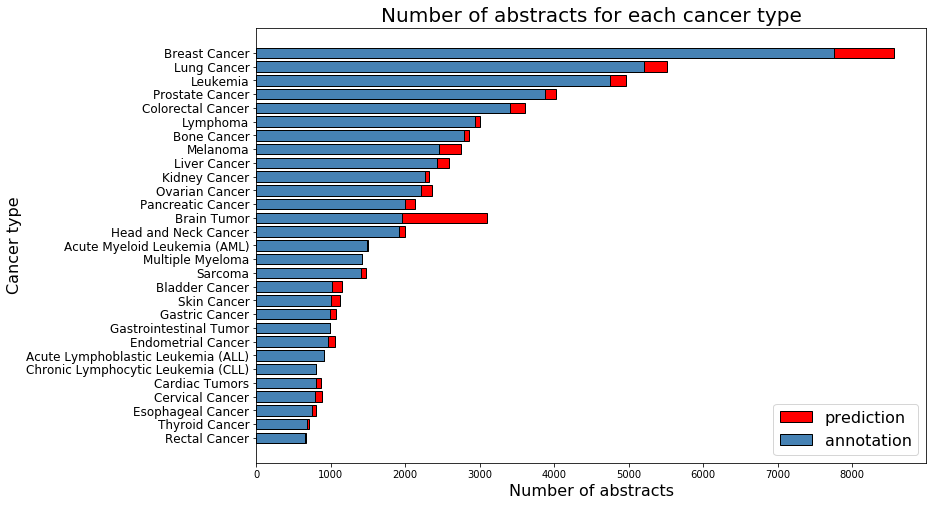

In [131]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(cancer_counts29_df2))  # the x locations for the groups
ax.barh(ind, cancer_counts29_df2.counts2, width, edgecolor='black',color='red',label='prediction')
ax.barh(ind, cancer_counts29_df2.counts1, width, edgecolor='black',color='steelblue',label='annotation')
ax.invert_yaxis()
plt.yticks(ind, labels = cancer_counts29_df2.index, fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0,110)
plt.ylabel('Cancer type', fontsize=16)
plt.xlabel('Number of abstracts', fontsize=16)
plt.title('Number of abstracts for each cancer type', fontsize=20)
plt.legend(fontsize=16)

As we can see from the barplot above, the relative percentage of abstracts for each cancer type is consistent in labeled and unlabeled corpus.